In [1]:
%matplotlib inline
import math
from types import SimpleNamespace
import numpy as np
import sympy
from sympy import Symbol, solve
from scipy.integrate import odeint
import matplotlib.pyplot as plt
from copy import deepcopy as DC
from mpl_toolkits.mplot3d import Axes3D
sympy.init_printing()

# Conventions
Origin: On the ground below plane at $t_0$.

X axis [0]: 90 degrees clockwise of Y axis.

Y axis [1]: Direction of helicopter ground track.

Z axis [2]: Pointed up vertically.

Absolute velocity (for determining position) is with respect to the ground.

Relative velocity (for determining drag) is with respect to the wind.

East: 0 degrees, i.e. direction of positive X axis.

North: 90 degrees, i.e. direction of positive Y axis.

Note, these conventions are somewhat arbitrary and selected for convenience. In the Monte Carlo simulations, we utilize a different set of conventions that corresponds to the perspective of an aviation pilot.

# Assumptions
* The system is released at a fixed height of 2000 ft.
    * This height is slightly varied in the Monte Carlo simulations.
* The system exits the helicopter at a right angle with a small velocity.
* The wind is blowing in exactly one direction at all times.
    * This seems acceptable since it takes about 1 minute to complete a trajectory.
* The helicopter is traveling directly against the wind at a constant velocity when the system is released.
    * The angle of incidence can be changed pretty easily by specifying the helicopter and wind directions with respect to the ground.
* The static line is about 2 m long and the system only drops straight down until it becomes taut.
    * It would be trivial to use our quartic function to bypass the assumption of it dropping straight down, but this is negligible.
* Deployment timer and actuation of eNSR ring, which releases drogue parachute, takes 4 s.
* Drag doesn't take effect until the drogue line goes taut.
    * Additionally, the drogue chute immediately unfurls and remains in the same location until the line is taut.
* The lines connecting the drogue chute to the 50 ft shock cord are negligible.
* The drogue pulls out at an angle, i.e. hold the drogue at the point of deployment and use Pythagorean theorem with the shock cord as the hypotenuse which follows the system's trajectory.
* When line becomes taut, drogue effects drag forces instantaneously.
* When main chute deploys 10 seconds after drogue chute's line becomes taut, it instantly takes effect on drag.
* The terrain is flat and free of objects.
* The density of air is held constant over the altitude range in consideration.
* The variation in wind speed is an exponential function of altitude, with respect to fixed values set at the beginning of a trajectory.

# Variables
|Variable | Symbol | Meaning|
|---|---|---|
|g | $g$ | standard gravity (m/s^2)|
|rho | $\rho$ | density of air (kg/m^3)|
| epsilon | $\epsilon$| an arbitrarily small number|
|m | $m$ | mass of system (kg) |
| drop_height | ---| height system is dropped from (m)|
| sl | $sl$ | length of static line (m)|
|d_deploy_t| --- | drogue deployment timer (s)|
| r_d | $r_d$ | radius of drogue chute (m) |
| dl | $dl$ | length of drogue line (m) |
| vt_d  |$vt_d$| terminal velocity of drogue (m/s) |
| c_deploy_t| ---| main chute deployment timer (s) |
| r_c | $r_c$ |radius of main chute (m) |
| C_d_c | $C_{d,c}$ | drag coefficient of main chute |
| C_d_dud | $C_{d,dud}$ | drag coefficient of dud system |
|A_dud| $A_{dud}$ | frontal area of dud system (m^2)|


# SOP
You can modify assumptions on the fly in this document. It runs a sim with default values and graphs it automatically. Keep in mind that you can use main() with its arguments to specify some of the variables of the model, but some variables are hardcoded as parameters. Also remember that this tool has been broken into many functions for a reason. We will import it as a library in another document and run many different sims to compare, so it has been coded with that in mind.

### Facts

In [2]:
# g = acceleration due to gravity [kg*m/s^2]
g = -9.80665
# density of air [kg/m^3]
rho = 1.2 # rough estimate

# simulation timestep [s]
epsilon = 10**(-10) # just in case we want a small number
time_step = 0.25

### Physical Parameters
120in. Rocketman High Performance CD 2.2 Parachute. This is our main parachute.

https://the-rocketman.com/high-performance-parachutes/

We use this site to eyeball the terminal velocity of the drogue parachute.

https://web.archive.org/web/20181110101551/http://the-rocketman.com/drogue-decent-rate.html

Also from the manufacturer are specs for the drogue, so we don't have to eyeball it.
https://the-rocketman.com/ballistic-parachutes/

In [3]:
# mass of payload [kg]
m = 25.35581 # up to date # 6.4 without sandbags
drop_height = 85 #609.6 # [m] (2000 ft)

# static line length [m]
sl = 1.
# drogue deployment timer [s]
d_deploy_t = 0.1 # estimate

# radius of drogue [m]
r_d = 0.762
# drogue line length [m]
dl = 3 #42. * 0.3048 # meters
# terminal velocity of drogue [m/s]
vt_d = -16.764 # rough eyeball estimate from rocketman link above

# main chute deployment timer [s]
c_deploy_t = 1.5 #17 # estimate
# main line length [m]
ml = 2 #30. * 0.3048 # meters

# radius of main chute [m]
r_c = 3.048 / 2 # [m] (120 in diameter)
# drag coefficients of main chute [m/s]
C_d_c = 2.2 # from rocketman, or your money back

C_d_dud = 0.3 # this is entirely an arbitrary guess. kinda close to a car, kinda close to lv4
A_dud = np.pi* 0.127**2 # [m] (5 in radius) i pulled this number out of a hat but we could probably just measure it

### Preliminary Calculations
Source [http://www.pcprg.com/rocketre.htm]

In [4]:
weight = abs(m * g) # drag force at terminal velocity [N]

A_d = np.pi * r_d**2 # frontal area of drogue [m^2]
C_d_d = (2 * weight) / (rho * A_d * vt_d**2) # drag coeff. of drogue, calculated 0.808, manufacturer says 0.97
C_d_d = 0.97
A_c = np.pi * r_c**2 # frontal area of main chute [m^2]

def term_vel(C_d, A):
    return -np.sqrt(2* weight/(C_d * rho *A))

vt_c = term_vel(C_d_c, A_c)

### Functions

In [5]:
def m_to_ft(x): # convert meters to feet
    return 3.28084 * x

def ms_to_knots(v): # convert m/s to knots
    return 1.943844 * v

# passively rotates a coordinate frame with a fixed vector. to go from relative to absolute
def rotate(x, theta):
    R = np.array([[np.cos(theta), - np.sin(theta)],
                  [np.sin(theta), np.cos(theta)]])
    return R.dot(x)

# https://en.wikipedia.org/wiki/Wind_profile_power_law
# assuming stable atmosphere over land without too rough
# of terrain and wind measurements at 10 m
def wind_profile(z, u_0, z_0=10, alpha=0.143):
    if z < 0: z = 0
    return u_0 * (z / z_0)**alpha

# calculates drag in all directions
# note that i am assuming that drag splits up in all dimensions equally
# idk if i should be assuming something about laminar flow in horizontal plane
# because i just learned what that even was
def drag_forces(v, C_d, A):
    norm = np.linalg.norm(v)
    return (-A/2 * C_d * rho * norm) * v

# solve a quartic to find the time at which the drogue chute becomes taut
# i'll make the names more iconic later, for now its fine
# at some point i'll do some actual math and make sure this can only return one positive real instead of assuming
def quartic(v_now, cord_len):
    Ps, vds, gs, Lvds, Lhds, tds, vcs, side = sympy.symbols('Ps vds gs Lvds Lhds tds vcs side')
    Dparms = {side: v_now[0], Ps: v_now[1], vcs: v_now[2], gs: g}
    tdEqn = (side*tds)**2 + (Ps*tds)**2 + (vcs*tds + 0.5*gs*tds**2)**2 - cord_len**2
    tdSolns = sympy.solve(tdEqn.subs(Dparms))
    for soln in [complex(x) for x in tdSolns]:
        if (soln.imag > epsilon) or (soln.real <= 0):
        #if (soln.imag != 0) or (soln.real <= 0):
            pass
        else:
            td = soln.real
    return td

# func for integrating. dis our ODE
# i know it's kinda weird to put logic inside an ode but it made sense at the time
def ode_f(x, v, t, phs, st8, v_w):
    wind = np.array([wind_profile(x[2], v_wi) for v_wi in v_w])
    if phs['live']: # drogue or chute active
        if phs['steadystate']: # aerodynamic equilibrium
            rel_v = np.zeros(3)
            abs_v = wind
            rel_v[2], abs_v[2] = (vt_c, vt_c) if phs['mainchute'] else (vt_d, vt_d)
        else:
            rel_v = v - wind
            abs_v = v
        # remember that drag depends on velocity of object relative to medium
        D = drag_forces(rel_v, st8[0], st8[1]) / m
    elif not phs['live']:
        rel_v = v - wind
        D = drag_forces(rel_v, C_d_dud, A_dud) / m # took a stab at guessing dud parameters, plz sanitize eventually
        abs_v = v
    a = D + np.array([0, 0, g])
    return np.array([abs_v, a])

# runge kutta integrator
def runge_kutta(sim, next_step):
    dt = sim.dt
    k1 = ode_f(sim.x[-1],
            sim.v[-1],
            sim.t[-1],
            sim.phase,
            sim.state,
            sim.v_w)
    k2 = ode_f(sim.x[-1] + k1[0] * dt/2,
            sim.v[-1] + k1[1] * dt/2,
            sim.t[-1] + dt/2,
            sim.phase,
            sim.state,
            sim.v_w)
    k3 = ode_f(sim.x[-1] + k2[0] * dt/2,
            sim.v[-1] + k2[1] * dt/2,
            sim.t[-1] + dt/2,
            sim.phase,
            sim.state,
            sim.v_w)
    k4 = ode_f(sim.x[-1] + k3[0] * dt,
            sim.v[-1] + k3[1] * dt,
            sim.t[-1] + dt,
            sim.phase,
            sim.state,
            sim.v_w)
    next_step.x = sim.x[-1] + dt * (k1[0] + 2*k2[0] + 2*k3[0] + k4[0]) / 6
    next_step.v = sim.v[-1] + dt * (k1[1] + 2*k2[1] + 2*k3[1] + k4[1]) / 6
    next_step.t = sim.t[-1] + dt
    next_step.a = (k1[1] + 2*k2[1] + 2*k3[1] + k4[1]) / 6

# keep eyebleed hidden
def update(sim, next_step):
    sim.x = np.append(sim.x, [next_step.x], axis=0)
    sim.v = np.append(sim.v, [next_step.v], axis=0)
    sim.t = np.append(sim.t, next_step.t)
    sim.a = np.append(sim.a, [next_step.a], axis=0)

# this is gonna get called during each phase for some amount of time
def iterate(sim, next_step, time):
    start = sim.t[-1] # offset
    # pretttttyy logic
    while (not sim.phase['mainchute'] and sim.t[-1] < start+time) or (sim.phase['mainchute'] and sim.x[-1][2] > 0):
        runge_kutta(sim, next_step)
        update(sim, next_step)
        if sim.x[-1][2] <= 0: break # kind of a kludge in case drogue fails and we impact before main deploys
        
        if sim.assume_limit: # in case we want to check whether we're close to terminal velocity
            terminal = vt_c if sim.phase['mainchute'] else vt_d
            if abs(next_step.v[2] - terminal) < epsilon: sim.phase['steadystate'] = True # jump to steady state

# no interesting code in this func, just graphing stuff
def graph_sol(sim, start=0, end=None):
    # break out the solutions into convenient names:
    #time = sim.t[start:end]
    soln_d_x = [s[0] for s in sim.x][start:end]
    soln_d_y = [s[1] for s in sim.x][start:end]
    #distance = [np.linalg.norm([soln_d_x[i], soln_d_y[i]]) for i in range(len(soln_d_x))]
    soln_d_z = [s[2] for s in sim.x][start:end]
    #soln_d_xdot = [s[0] for s in sim.v][start:end]
    #soln_d_ydot = [s[1] for s in sim.v][start:end]
    #horiz_v = [np.linalg.norm([soln_d_xdot[i], soln_d_ydot[i]]) for i in range(len(soln_d_x))]
    #soln_d_zdot = [s[2] for s in sim.v][start:end]
    
    # plot da shiz:
    fig = plt.figure(1)
    ax = fig.add_subplot(111, projection='3d')
    ax.plot(soln_d_x, soln_d_y, soln_d_z)
    ax.grid()
    plt.title('Trajectory')
    
    plt.figure(2)
    plt.plot(sim.t, sim.x)
    plt.xlabel('time (s)')
    plt.ylabel('position (m)')
    plt.legend(['x', 'y', 'z'])
    
    plt.figure(3)
    plt.plot(sim.t, sim.v)
    plt.xlabel('time (s)')
    plt.ylabel('velocity (m/s)')
    plt.legend(['x', 'y', 'z'])
    
    plt.figure(8)
    plt.plot(sim.t, sim.a)
    plt.xlabel('time (s)')
    plt.ylabel('acceleration (m/s^2)')
    plt.legend(['x', 'y', 'z'])
    
    
    
    plt.figure(7)
    plt.plot(sim.x[0][0], sim.x[0][1],'r^')
    plt.plot(sim.x[-1][0], sim.x[-1][1],'bs')
    plt.xlabel('First (r) and Last (b) X pos')
    plt.ylabel('First (r) and Last (b) Y pos')
    plt.grid()
    plt.axis('equal')
    
    

### Flight plan

No Failures detected!

Static Line Taut. Time: 0.455

Drogue Deployed. Time: 0.555

Line Taut. Time: 1.96

Drogue Actively Dragging. Time: 1.96

Main Deployed. Time: 3.465

Line Taut. Time: 4.585

Main Chute Actively Dragging. Time: 4.585

Test Article Landed. Time: 7.465

TOTAL HORIZONTAL DISTANCE FROM ORIGIN: 26.74 m = 87.74 ft
TOTAL VERTICAL DISTANCE DESCENDED: 85.01 m = 278.9 ft
TOTAL TIME FOR DESCENT: 7.46 s = 0.12 min
Final coordinates: (x, y) = ( 26.744543411193092 , 4.0263906135755924e-17 )


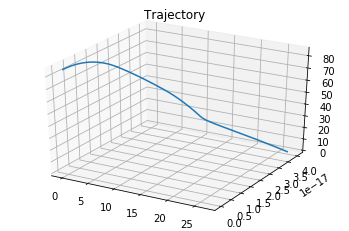

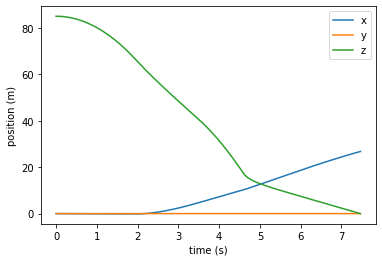

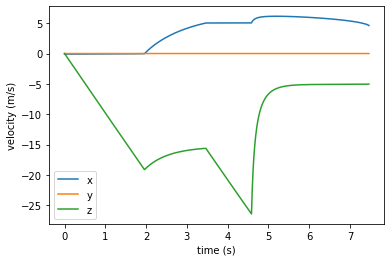

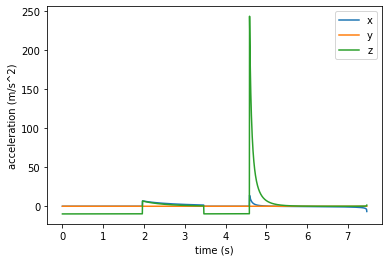

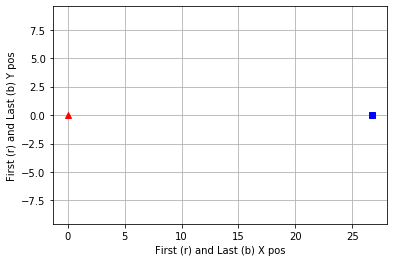

In [6]:
phase = {'live': False, 'steadystate': False, 'mainchute': False}
fail_mode = {'drogue': False, 'mainchute': False, 'early': False}

# we're using this to set conditions in the model based on an abstract code (i.e. A,B,C,D)
def set_failure_mode(sim, mode):
    sim.fail_mode = DC(fail_mode)
    if mode == 'A':
        sim.fail_mode['mainchute'] = True
        if sim.prnt: print('Main Chute Failure!\n')
    elif mode == 'B':
        sim.fail_mode['drogue'] = True
        if sim.prnt: print('Drogue Failure!\n')
    elif mode == 'C':
        sim.fail_mode['drogue'] = True
        sim.fail_mode['early'] = True
        if sim.prnt: print('Drogue Failure and Early Main Chute Deployment!\n')
    elif mode == 'D': # d is for dud, it's good enough for me
        sim.fail_mode['mainchute'] = True
        sim.fail_mode['drogue'] = True
        if sim.prnt: print('Recovery system is a dud! Now Im freee. Free fallin!\n')
    else:
        if sim.prnt: print('No Failures detected!\n')

# in case we want to track the simulation as it occurs
def test_print(next_step):
    print('t: ',next_step.t, '. x: ', next_step.x, '. v: ', next_step.v)

# initialize a trajectory simulation with all relevant parameters
def init(v_plane=18, v_side=0.1, deg_plane=180, v_wind=3.1, deg_wind=45, x_0_offset=[0, 0, 0], t_0=0,
         mode='', dt=time_step, prnt=False):
    # v_plane = forward ground speed of plane (m/s)
    # deg_plane = bearing of plane on unit circle
    # v_side = cross wind ground speed of system (m/s)
    # v_wind = average wind speed (m/s)
    # deg_wind = bearing of wind on unit circle
    
    # bearing of plane in radians
    theta_plane = np.radians(deg_plane)
    # bearing of wind in radians
    theta_wind = np.radians(deg_wind)
    
    dir_w = np.array([np.cos(theta_wind), np.sin(theta_wind), 0])
    
    next_step = SimpleNamespace()
    next_step.x, next_step.v, next_step.t, next_step.a = np.zeros(3), np.zeros(3), np.zeros(1), np.zeros(3)
    sim = SimpleNamespace()
    sim.v_w = dir_w * v_wind
    
    # here is our state space!
    sim.x = np.array([np.array([0, 0, drop_height]) + np.array(x_0_offset)])
    vel = rotate(np.array([v_plane, -v_side]), theta_plane)
    sim.v = np.array([np.array([vel[0], vel[1], 0])])
    sim.t = np.array([t_0])
    sim.a = np.array([np.array([0,0,g])])
    
    sim.dt = dt
    sim.prnt = prnt # silent by default
    sim.state = [C_d_dud, A_dud] 
    sim.phase = DC(phase) # keep track of boolean states
    set_failure_mode(sim, mode) # handle the logic of failure modes so we have high level simple controls
    sim.assume_limit = False # True if we want to assume natural (not forced) convergence to terminal velocity
    return sim, next_step

# half deprecated
def main_chute_steady(sim, next_step):
    if sim.prnt: print('Main Chute Actively Dragging!\n')
    # safety distance above the ground that the main chute should deploy at [m]
    safety_dist= 304.8 # = 1000 ft
    # time until ground impact from safety distance at main chute's terminal velocity
    chute_t = abs(safety_dist / vt_c)
    duration = chute_t
    if not sim.fail_mode['mainchute']: sim.state = [C_d_c, A_c] # use main chute drag if it isn't failing
    # if main chute fails, drag is only live if the drogue didn't fail. if drogue failed, we free fall
    sim.phase['live'] = True if not sim.fail_mode['mainchute'] else not sim.fail_mode['drogue']
    sim.phase['mainchute'] = True # either way we fall until impact
    sim.phase['steadystate'] = True # jump straight to steady state
    
    # kludge to account for jumping from one steady state to another
    sim.v[-1][0] = sim.v_w[0]
    sim.v[-1][1] = sim.v_w[1]
    sim.v[-1][2] = vt_c
    
    iterate(sim, next_step, duration)

### these are the important steps, cleanly presented
def static_line(sim, next_step):
    duration = np.sqrt(abs(2 * sl / g))
    iterate(sim, next_step, duration)
    if sim.prnt: print('Static Line Taut. Time: '+str(round(sim.t[-1], 4))+'\n')

def drogue_deploy(sim, next_step): # and eNSR ring separation
    duration = d_deploy_t
    iterate(sim, next_step, duration)
    if sim.prnt: print('Drogue Deployed. Time: '+str(round(sim.t[-1], 4))+'\n')

def until_line_taut(sim, next_step, cord_len):
    sim.state = [C_d_dud, A_dud]
    duration = quartic(sim.v[-1], cord_len) + 1 # extra time to account for unfurling
    iterate(sim, next_step, duration)    
    if sim.prnt: print('Line Taut. Time: '+str(round(sim.t[-1], 4))+'\n')

def drogue_action(sim, next_step):
    if sim.prnt: print('Drogue Actively Dragging. Time: '+str(round(sim.t[-1], 4))+'\n')
    sim.state = [C_d_d, A_d] 
    duration = c_deploy_t
    sim.phase['live'] = not sim.fail_mode['drogue'] # not a dud, unless it is
    iterate(sim, next_step, duration)
    if sim.prnt: print('Main Deployed. Time: '+str(round(sim.t[-1], 4))+'\n')

def main_chute(sim, next_step):
    if sim.prnt: print('Main Chute Actively Dragging. Time: '+str(round(sim.t[-1], 4))+'\n')
    if not sim.fail_mode['mainchute']:
        sim.state = [C_d_c, A_c] # use main chute drag if it isn't failing
    else:
        sim.state = [C_d_d, A_d] # keep drogue on
    # if main chute fails, drag is only live if the drogue didn't fail. if drogue failed, we free fall
    sim.phase['live'] = True if not sim.fail_mode['mainchute'] else not sim.fail_mode['drogue']
    sim.phase['mainchute'] = True # either way we fall until impact
    iterate(sim, next_step, 0) # time condition doesn't matter since determined by height
    if sim.prnt: print('Test Article Landed. Time: '+str(round(sim.t[-1], 4))+'\n')

# run this sim! so pretty!
def trajectory(v_plane=18, v_side=0.0, deg_plane=180, v_wind=3.1, deg_wind=0, x_0_offset=[0, 0, 0], t_0=0,
         mode='', dt=time_step, prnt=False):
    sim, next_step = init(v_plane, v_side, deg_plane, v_wind, deg_wind, x_0_offset, t_0,
                          mode, dt, prnt)
    static_line(sim, next_step)
    drogue_deploy(sim, next_step)
    if not sim.fail_mode['early']: # skip drogue and go straight to main chute if failure mode is early deployment
        until_line_taut(sim, next_step, dl)
        drogue_action(sim, next_step)
    if not sim.fail_mode['mainchute']:
        until_line_taut(sim, next_step, ml) # to account for unfurling of main chute after drogue is jettisoned
    main_chute(sim, next_step)
    
    return (np.array([sim.x[-1][0], sim.x[-1][1]]), sim)
    
# this block is so that our notebook won't automatically run a sim when it is imported ;)
if __name__ == '__main__' and not '__file__' in globals():
    coords, results = trajectory(v_plane=0.1, v_wind=6., dt=0.005, prnt=True)
    
    print('TOTAL HORIZONTAL DISTANCE FROM ORIGIN:', round(np.linalg.norm(results.x[-1][0:2]), 2),
          'm', '=', round(np.linalg.norm(results.x[-1][0:2]) * 3.28084, 2), 'ft')
    print('TOTAL VERTICAL DISTANCE DESCENDED:', round(drop_height - results.x[-1][2], 2),
          'm', '=', round((drop_height - results.x[-1][2]) * 3.28084, 2), 'ft')
    print('TOTAL TIME FOR DESCENT:', round(results.t[-1], 2), 's =', round(results.t[-1] / 60, 2), 'min')
    
    print('Final coordinates: (x, y) = (', coords[0], ",", coords[1],')')
    graph_sol(results, start=0, end=None)

# Remark
Recall that this will be used by a simulator upstream. It will be run many times, so that simulator will stipulate a new time step that is much rougher. To verify that this doesn't significantly harm our model, we will run the above simulation which was run at dt=0.005 a second time at the Monte Carlo time step of dt=0.25 so we can compare the results and get a sense of how consistent the two numerical integrations are.

Then we will run a third time using the manual methods which should save some time without effecting the results.

No Failures detected!

Static Line Taut. Time: 0.5

Drogue Deployed. Time: 0.6

Line Taut. Time: 2.0

Drogue Actively Dragging. Time: 2.0

Main Deployed. Time: 3.55

Line Taut. Time: 4.7

Main Chute Actively Dragging. Time: 4.7

Test Article Landed. Time: 7.1

TOTAL HORIZONTAL DISTANCE FROM ORIGIN: 24.49 m = 80.35 ft
TOTAL VERTICAL DISTANCE DESCENDED: 85.15 m = 279.35 ft
TOTAL TIME FOR DESCENT: 7.1 s = 0.12 min
Final coordinates: (x, y) = ( 24.490818891427196 , 0.0 )


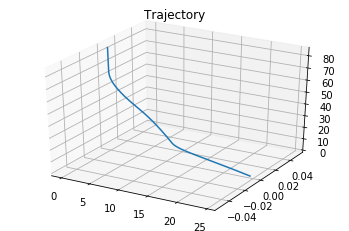

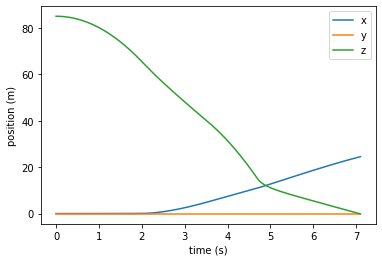

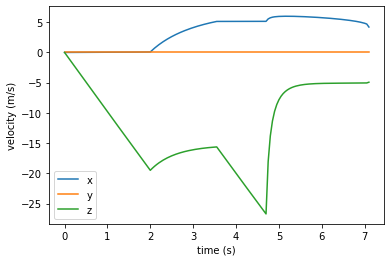

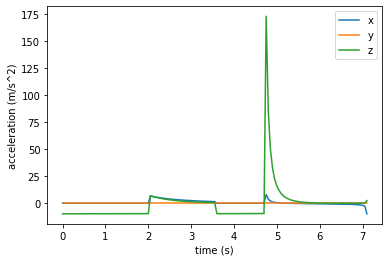

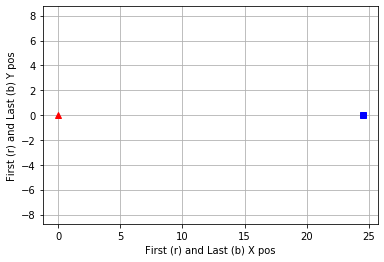

In [7]:
if __name__ == '__main__' and not '__file__' in globals():
    coords, results = trajectory(v_plane=00., v_wind=6., dt=0.05, prnt=True)

    print('TOTAL HORIZONTAL DISTANCE FROM ORIGIN:', round(np.linalg.norm(results.x[-1][0:2]), 2),
          'm', '=', round(np.linalg.norm(results.x[-1][0:2]) * 3.28084, 2), 'ft')
    print('TOTAL VERTICAL DISTANCE DESCENDED:', round(drop_height - results.x[-1][2], 2),
          'm', '=', round((drop_height - results.x[-1][2]) * 3.28084, 2), 'ft')
    print('TOTAL TIME FOR DESCENT:', round(results.t[-1], 2), 's =', round(results.t[-1] / 60, 2), 'min')
    
    print('Final coordinates: (x, y) = (', coords[0], ",", coords[1],')')
    graph_sol(results, start=0, end=None)



# Failure Modes
Now we will investigate our failure modes. The cases are A (no main chute), B (no drogue), C (no drogue and early main deployment), and D (total dud). Note that a blank case will represent mission success. Also note that we are still ignoring drag from the body of the recovery system. I would prefer to account for it, but I have yet to estimate its coefficients. As such, there is no difference between case B and case D, since the main chute deploys after impact without a drogue to slow descent. Therefore, we will only check the success case, case A, case B, and case C in our Monte Carlo simulation.

I've checked the default wind/plane scenario and found that the variance between smooth and rough trajectories seems negligible for our failure modes as well. You are free to double check yourself, it only requires changing which trajectory function you run. I ran the smooth trajectory here because the graphs from trajectory_fast() are uninsightful.

Recovery system is a dud! Now Im freee. Free fallin!

Static Line Taut. Time: 0.455

Drogue Deployed. Time: 0.555

Line Taut. Time: 1.96

Drogue Actively Dragging. Time: 1.96

Main Deployed. Time: 3.465

Main Chute Actively Dragging. Time: 3.465

Test Article Landed. Time: 4.19

TOTAL HORIZONTAL DISTANCE FROM ORIGIN: 0.4 m = 1.32 ft
TOTAL VERTICAL DISTANCE DESCENDED: 85.13 m = 279.31 ft
TOTAL TIME FOR DESCENT: 4.19 s = 0.07 min
Final coordinates: (x, y) = ( 0.40225799956200603 , 0.0 )


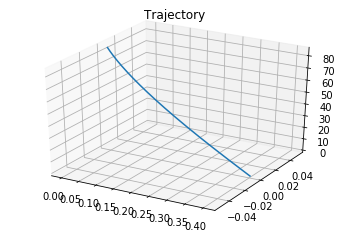

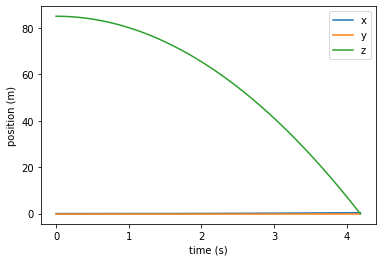

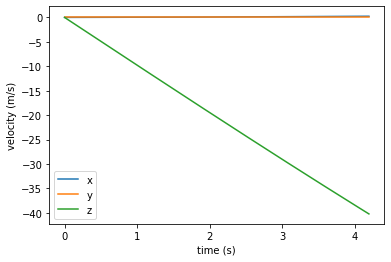

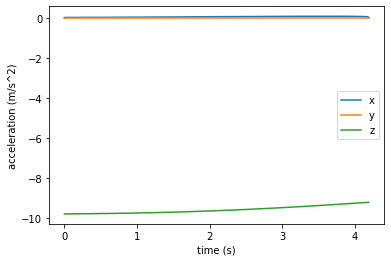

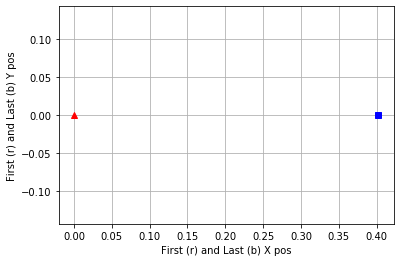

In [8]:
# this block is so that our notebook won't automatically run a sim when it is imported ;)
if __name__ == '__main__' and not '__file__' in globals():
    coords, results = trajectory(v_plane=00., v_wind=6., mode='D', dt=0.005, prnt=True)

    print('TOTAL HORIZONTAL DISTANCE FROM ORIGIN:', round(np.linalg.norm(results.x[-1][0:2]), 2),
          'm', '=', round(np.linalg.norm(results.x[-1][0:2]) * 3.28084, 2), 'ft')
    print('TOTAL VERTICAL DISTANCE DESCENDED:', round(drop_height - results.x[-1][2], 2),
          'm', '=', round((drop_height - results.x[-1][2]) * 3.28084, 2), 'ft')
    print('TOTAL TIME FOR DESCENT:', round(results.t[-1], 2), 's =', round(results.t[-1] / 60, 2), 'min')
    
    print('Final coordinates: (x, y) = (', coords[0], ",", coords[1],')')
    graph_sol(results, start=0, end=None)

Drogue Failure!

Static Line Taut. Time: 0.455

Drogue Deployed. Time: 0.555

Line Taut. Time: 1.96

Drogue Actively Dragging. Time: 1.96

Main Deployed. Time: 3.465

Line Taut. Time: 4.19

Main Chute Actively Dragging. Time: 4.19

Test Article Landed. Time: 4.19

TOTAL HORIZONTAL DISTANCE FROM ORIGIN: 0.4 m = 1.32 ft
TOTAL VERTICAL DISTANCE DESCENDED: 85.13 m = 279.31 ft
TOTAL TIME FOR DESCENT: 4.19 s = 0.07 min
Final coordinates: (x, y) = ( 0.40225799956200603 , 0.0 )


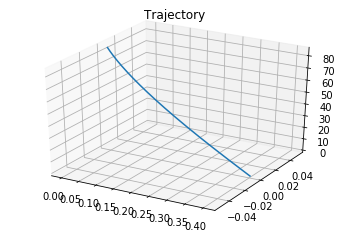

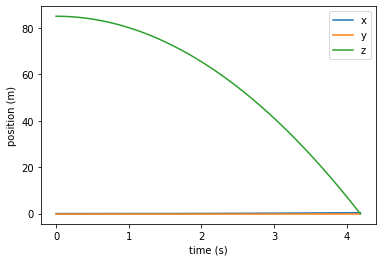

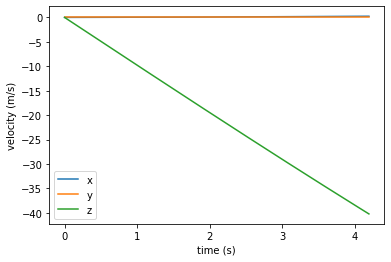

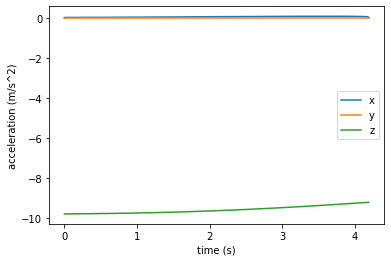

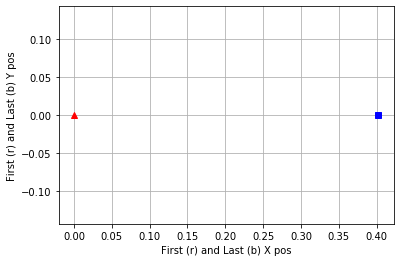

In [9]:
# this block is so that our notebook won't automatically run a sim when it is imported ;)
if __name__ == '__main__' and not '__file__' in globals():
    coords, results = trajectory(v_plane=0., v_wind=6., mode='B', dt=0.005, prnt=True)

    print('TOTAL HORIZONTAL DISTANCE FROM ORIGIN:', round(np.linalg.norm(results.x[-1][0:2]), 2),
          'm', '=', round(np.linalg.norm(results.x[-1][0:2]) * 3.28084, 2), 'ft')
    print('TOTAL VERTICAL DISTANCE DESCENDED:', round(drop_height - results.x[-1][2], 2),
          'm', '=', round((drop_height - results.x[-1][2]) * 3.28084, 2), 'ft')
    print('TOTAL TIME FOR DESCENT:', round(results.t[-1], 2), 's =', round(results.t[-1] / 60, 2), 'min')
    
    print('Final coordinates: (x, y) = (', coords[0], ",", coords[1],')')
    graph_sol(results, start=0, end=None)

Main Chute Failure!

Static Line Taut. Time: 0.455

Drogue Deployed. Time: 0.555

Line Taut. Time: 1.96

Drogue Actively Dragging. Time: 1.96

Main Deployed. Time: 3.465

Main Chute Actively Dragging. Time: 3.465

Test Article Landed. Time: 6.14

TOTAL HORIZONTAL DISTANCE FROM ORIGIN: 20.76 m = 68.1 ft
TOTAL VERTICAL DISTANCE DESCENDED: 85.01 m = 278.89 ft
TOTAL TIME FOR DESCENT: 6.14 s = 0.1 min
Final coordinates: (x, y) = ( 20.757935607375707 , 0.0 )


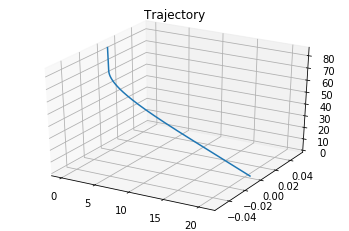

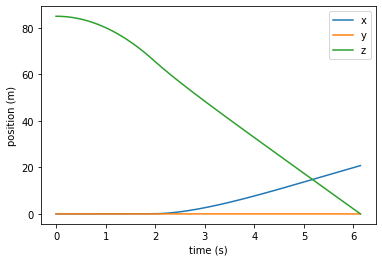

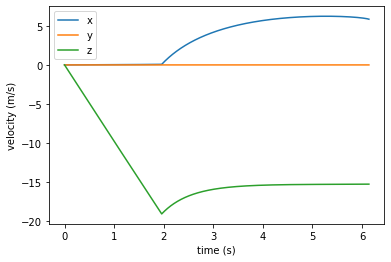

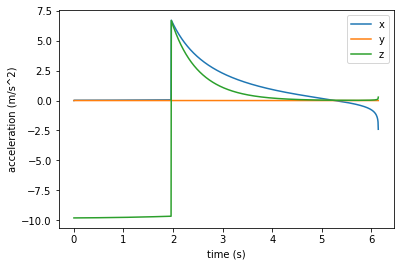

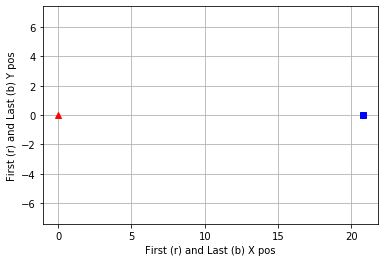

In [10]:
# this block is so that our notebook won't automatically run a sim when it is imported ;)
if __name__ == '__main__' and not '__file__' in globals():
    coords, results = trajectory(v_plane=0., v_wind=6., mode='A', dt=0.005, prnt=True)

    print('TOTAL HORIZONTAL DISTANCE FROM ORIGIN:', round(np.linalg.norm(results.x[-1][0:2]), 2),
          'm', '=', round(np.linalg.norm(results.x[-1][0:2]) * 3.28084, 2), 'ft')
    print('TOTAL VERTICAL DISTANCE DESCENDED:', round(drop_height - results.x[-1][2], 2),
          'm', '=', round((drop_height - results.x[-1][2]) * 3.28084, 2), 'ft')
    print('TOTAL TIME FOR DESCENT:', round(results.t[-1], 2), 's =', round(results.t[-1] / 60, 2), 'min')
    
    print('Final coordinates: (x, y) = (', coords[0], ",", coords[1],')')
    graph_sol(results, start=0, end=None)

Drogue Failure and Early Main Chute Deployment!

Static Line Taut. Time: 0.455

Drogue Deployed. Time: 0.555

Line Taut. Time: 1.85

Main Chute Actively Dragging. Time: 1.85

Test Article Landed. Time: 14.905

TOTAL HORIZONTAL DISTANCE FROM ORIGIN: 89.32 m = 293.05 ft
TOTAL VERTICAL DISTANCE DESCENDED: 85.02 m = 278.93 ft
TOTAL TIME FOR DESCENT: 14.91 s = 0.25 min
Final coordinates: (x, y) = ( 89.32129123860521 , 0.0 )


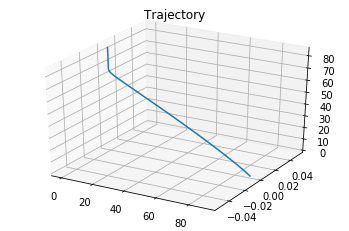

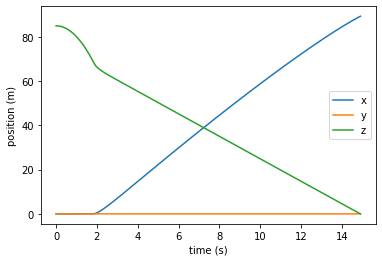

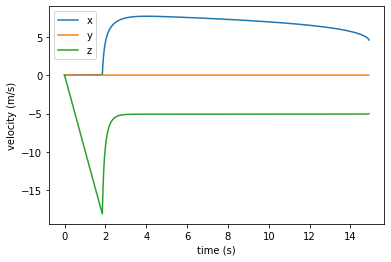

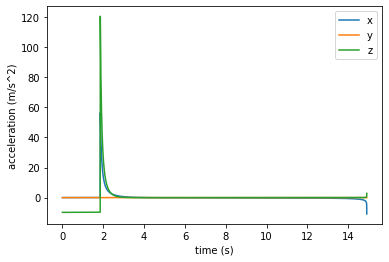

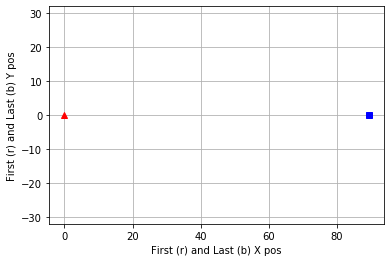

In [11]:
# this block is so that our notebook won't automatically run a sim when it is imported ;)
if __name__ == '__main__' and not '__file__' in globals():
    coords, results = trajectory(v_plane=0., v_wind=6., mode='C', dt=0.005, prnt=True)

    print('TOTAL HORIZONTAL DISTANCE FROM ORIGIN:', round(np.linalg.norm(results.x[-1][0:2]), 2),
          'm', '=', round(np.linalg.norm(results.x[-1][0:2]) * 3.28084, 2), 'ft')
    print('TOTAL VERTICAL DISTANCE DESCENDED:', round(drop_height - results.x[-1][2], 2),
          'm', '=', round((drop_height - results.x[-1][2]) * 3.28084, 2), 'ft')
    print('TOTAL TIME FOR DESCENT:', round(results.t[-1], 2), 's =', round(results.t[-1] / 60, 2), 'min')
    
    print('Final coordinates: (x, y) = (', coords[0], ",", coords[1],')')
    graph_sol(results, start=0, end=None)